# Проект  №8 "Возьмёте Бэтмобиль?"
## Предсказание цены подержанного автомобиля с использованием ML и DL
Команда "Отряд Дамблдора": Борис Красницкий и Анна Журавлёва
![](https://data.whicdn.com/images/341964063/original.jpg)

В ноутбуке будет решаться задача предсказания цены подержанного автомобиля по готовым датасетам с помощью комбинации Machine Learning  и Deep Learning.

# 1. Подготовка системы и данных
### 1.1 Загружаем необходимые для работы библиотеки

In [1]:
#!pip install -q tensorflow==2.3
#аугментации изображений
!pip install albumentations -q

#Библиотеки общего характера
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling #оценка датасета
import os
import sys
import PIL
import cv2
import re
import math
from textblob import TextBlob

# Входящие данные доступны в директории"../input/" directory, доступной только для чтения
#Загрузим библиотеки для машинного обучения и подготовки данных
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
YEAR = 2021

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Установим фиксированные условия, чтобы не повторять эти параметры в моделях

In [2]:
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

!pip freeze > requirements.txt

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Выведем версии основных библиотек

In [4]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 16:07:37) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1


### 1.2 Определим основные функции

In [5]:
#Функция подсчета результата 
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
#Таблица сравнения результатов каждой модели
def cumulated_res(data, model,description, mape,file):
    l = len(data)
    data.loc[l]= [mape, model, description,file]
    return data

### 1.3 Импорт и обзор данных

In [7]:
#Зададим путь
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'

#Определим датасеты из предложенных файлов
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

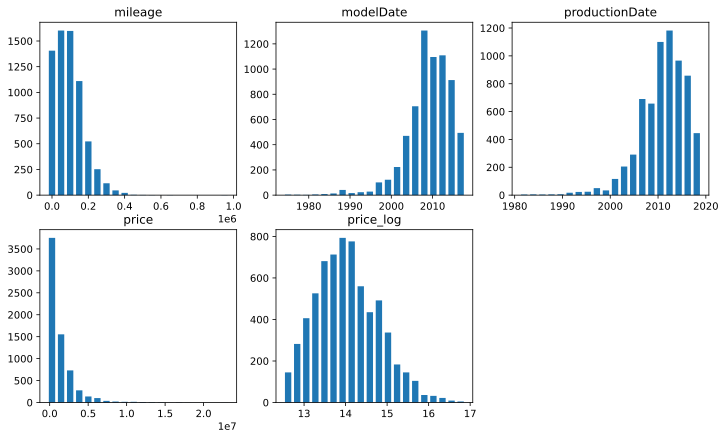

In [8]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 4, rows * 3.5))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    #ax.scatter(x = values, y = train['price'])
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna(), 
    'price': train['price'].dropna(), 
    'price_log': train['price'].apply(np.log),
})

In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


Применим библиотеку pandas_profiling для описания датасетов. С помощью одной строчки кода мы получаем полную статистическую информацию по каждому признаку: тип данных, пропущенные значения, подсчет значений, нулевые значения, графические представления и корреляции. 

In [10]:
#pandas_profiling.ProfileReport(data)

# Описание содержимого

1. bodyType - тип кузова автомобиля, категориальная переменная.
2. brand - марка автомобиля, категориальная переменная.
3. color - цвет автомобиля, категориальная переменная.
4. description - описание транспортного средства, текстовая переменная, требует обработки.
5. engineDisplacement - объем двигателя автомобиля, категориальная переменная, требует обработки.
6. enginePower - мощность двигателя автомобиля, категориальная переменная, требует обработки.
7. FuelType - тип топлива автомобиля, категориальная переменная.
8. mileage - пробег автомобиля, непрерывная переменная.
9. modelDate - год запуска производства, категориальная переменная.
10. model_info - серия автомобилей, категориальная переменная.
11. name - комбинация нескольких признаков, требующая обработки.
12. numberOfDoors - количество дверей автомобиля, категориальная переменная.
13. price - целевая переменная.
14. productionDate - год выпуска, категориальная переменная.
15. sell_id - внешний идентификатор, непрерывная переменная.
16. vehicleConfiguration - комбинация нескольких функций, требующих обработки.
17. vehicleTransmission - тип трансмиссии автомобиля, категориальная переменная.
18. Владельцы-количество владельцев, категориальная переменная.
19. Владение-время владения, требует обработки и исправления пропущенных значений.
20. ПТС - свидетельство о регистрации автомобиля, двоичная переменная.
21. Привод-компоновка автомобиля, категориальная переменная.
22. Руль-положение колеса автомобиля, категориальная переменная.

В объединенном датасете 8353 строк. В общей сложности представлены данные о 8353 автомобилях. Всего 21 переменная. Всего пропусков 5419 (или 64 % от общего количества строк), практически все пропуски в переменной 'Владение'. В рамках  проверки на наличие выбросов таковых не установлено (условно выбросами можно считать автомобили с пробегом свыше 400 тыс. км., но нами было принято решение не обрабатывать данные значения, ввиду того, что данные значения вполне могут отражать реальную ситуацию)

### 1.4 Очистка данных и получение новых признаков

In [11]:
# Переделаем признак 'enginePower' в числовой
data['enginePower'] = data['enginePower'].apply(lambda x: int(x.split(' ')[0].replace('.', '')))

In [12]:
# Сделаем числовым 'engineDisplacement'
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: '2.0 LTR' if x == 'undefined LTR' else x)
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: int(x.split(' ')[0].replace('.', '')))
data['engineDisplacement'].value_counts().head(3)

20    2436
30    2349
18     411
Name: engineDisplacement, dtype: int64

In [13]:
# Сдвинем даты относительно текущего года 
data['productionDate'] = data['productionDate'].apply(lambda x: YEAR - x)
data['modelDate'] = data['modelDate'].apply(lambda x: YEAR - x)

In [14]:
# Из числовых сделаем еще 3 новых признака:
# 'model_age' - новизна модели на момент производства с весом 0.1
data['model_age'] =  data['modelDate'] - data['productionDate']
data['model_age'] = data['model_age'].apply(lambda x: 0. if x < 0 else 0.1*x)

# 'km_pro_year' - cтепень эксплуатации(пробег/год)
data['km_pro_year'] = data['mileage']/(YEAR - data['productionDate'])

# 'mil_p' - отношение логарифма пробега к мощности
data['mil_p'] = data['mileage'].apply(lambda x: np.log(1. + x))/data['enginePower']

In [15]:
# Признак 'Владение' вряд ли является значимым и имеет 2/3 пропусков, но 
# является интересным в плане обработки, поэтому не выбрасываем его
data['Владение'].isna().value_counts()

True     5418
False    2935
Name: Владение, dtype: int64

In [16]:
# 'Владельцы' пока переделаем в числовой, чтобы рассчитать 'Владение',
# но позже обработаем его как категориальный
data['Владельцы'].fillna(data['Владельцы'][150], inplace=True)
data['Владельцы'] = data['Владельцы'].apply(lambda x: int(x[0]))
data['Владельцы'].value_counts()

3    3311
1    2526
2    2516
Name: Владельцы, dtype: int64

In [17]:
# 'Владение' в месяцах вычисляем где есть из текста, а пропущенные заменяем на
# возраст/кол-во владельцев
def own(x):    
    ''' extracts time in months from "Владение"'''
    
    try:
        pattern_year = re.compile('\d+ [гл]')
        pattern_month = re.compile('\d+ [м]')
        own_year = pattern_year.findall(x['Владение'])
        own_month = pattern_month.findall(x['Владение'])
        own_year.append('0')   # чтобы не было пустого списка
        own_month.append('0')
        return (float(own_year[0].split(' ')[0])*12 + float(own_month[0].split(' ')[0]))
    
    except:
        return x['productionDate']*12/x['Владельцы']

In [18]:
# Применяем ф-цию 
data['Владение'] = data.apply(lambda data: own(data), axis=1)
data['Владение'].value_counts().head()

36.0    623
24.0    574
48.0    529
60.0    406
72.0    274
Name: Владение, dtype: int64

In [19]:
# Используем текстовые признаки как категориальные без предобработки,
# за исключением 'name' и 'vehicleConfiguration' 
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'Владельцы', 
                        'numberOfDoors', 'vehicleTransmission', 'ПТС', 'Привод', 'Руль']

# числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'enginePower', 'engineDisplacement', 
                      'model_age', 'km_pro_year', 'mil_p', 'Владение']

In [20]:
# Пропущенных значений в числовых признаках нет
data[numerical_features].isna().value_counts()

mileage  modelDate  productionDate  enginePower  engineDisplacement  model_age  km_pro_year  mil_p  Владение
False    False      False           False        False               False      False        False  False       8353
dtype: int64

In [21]:

# В категориальных признаках тоже нет пропущенных значений
data[categorical_features].isna().value_counts()


bodyType  brand  color  fuelType  model_info  Владельцы  numberOfDoors  vehicleTransmission  ПТС    Привод  Руль 
False     False  False  False     False       False      False          False                False  False   False    8353
dtype: int64

In [22]:
# Посмотрим, что можно извлечь из этих признаков
data[['name', 'vehicleConfiguration']].sample(5)

,name,vehicleConfiguration
7399,28i xDrive 2.0 AT (245 л.с.) 4WD,ALLROAD_5_DOORS AUTOMATIC 2.0
4273,40e 2.0hyb AT (245 л.с.) 4WD,ALLROAD_5_DOORS AUTOMATIC 2.0
3362,63 AMG Long 5.5 AT (585 л.с.) 4WD,SEDAN AUTOMATIC 5.5
2794,3.0d AMT (245 л.с.) 4WD,SEDAN ROBOT 3.0
5378,525d xDrive 2.0d AT (218 л.с.) 4WD,SEDAN AUTOMATIC 2.0


In [23]:
data['name'].value_counts()

35i 3.0 AT (306 л.с.) 4WD                  151
2.0 AMT (211 л.с.) 4WD                     145
200 2.0 AT (184 л.с.)                      137
30d 3.0d AT (249 л.с.) 4WD                 109
400 3.0 AT (333 л.с.) 4WD                   97
                                          ... 
18i sDrive 1.5 AMT (140 л.с.)                1
4.0 AMT (450 л.с.) 4WD                       1
R 4.0 AMT (585 л.с.)                         1
740Li 4.4 AT (286 л.с.)                      1
220 d экстра длинный 2.1d AT (163 л.с.)      1
Name: name, Length: 976, dtype: int64

In [24]:
data['vehicleConfiguration'].value_counts()

ALLROAD_5_DOORS AUTOMATIC 3.0       1292
SEDAN AUTOMATIC 2.0                  941
SEDAN AUTOMATIC 3.0                  631
ALLROAD_5_DOORS AUTOMATIC 2.0        524
ALLROAD_5_DOORS ROBOT 2.0            226
                                    ... 
ROADSTER MECHANICAL 2.5                1
SEDAN AUTOMATIC 3.8                    1
HATCHBACK_5_DOORS MECHANICAL 1.5       1
CABRIO AUTOMATIC 1.8                   1
WAGON_5_DOORS AUTOMATIC 1.6            1
Name: vehicleConfiguration, Length: 312, dtype: int64

In [25]:
# Создадим признак 'allroad' для авто с полным приводом, используя данные из обоих столбцов
allroad1 = data['vehicleConfiguration'].apply(lambda x: 1 if 'ALLROAD' in x.split('_') else 0)
allroad2 = data['name'].apply(lambda x: 1 if '4WD' in x.split(' ') else 0)
data['allroad'] = (allroad1 + allroad2).apply(lambda x: 0 if x == 0 else 1)
categorical_features.append('allroad')
data['allroad'].value_counts()

1    5306
0    3047
Name: allroad, dtype: int64

In [26]:
# Выделим AMG, Maybach и BMW-M как наиболее дорогие модели
data['lux'] = data['model_info'].apply(lambda x: 1 if (x != 'M_KLASSE') & ('M' in x) or ('8' in x) else 0)
categorical_features.append('lux')
data[data['lux'] == 1].model_info.value_counts().head()

A8                 129
G_KLASSE_AMG        71
S_KLASSE_AMG        65
X6_M                61
S_CLASS_MAYBACH     45
Name: model_info, dtype: int64

In [27]:
# создаем новые переменные - автомобили с большим и малым пробегом.
data['low_MtA'] = 0
data['high_MtA'] = 0

# Creating new features.
counter = 0

for MtA in data['km_pro_year']:
    if MtA < 5000:
        data.at[counter,'low_MtA'] = 1
        counter += 1
    elif MtA > 30000:
        data.at[counter,'high_MtA'] = 1
        counter += 1
    else:
        counter += 1
        
categorical_features.append('low_MtA')
categorical_features.append('high_MtA')


In [28]:
#Внимательно посмотрим на пробег, как один из важных признаков. Создадим различные переменные в зависимости от пробега в разрезе различных моделей

mileage_by_model_info = data.groupby(['model_info'])['mileage'].agg(['mean', 'max', 'median', 'var', 'std'])
data['mean_mileage_by_model_info'] = data['model_info'].map(mileage_by_model_info['mean'])
data['max_mileage_by_model_info'] = data['model_info'].map(mileage_by_model_info['max'])
data['median_mileage_by_model_info'] = data['model_info'].map(mileage_by_model_info['median'])
data['var_mileage_by_model_info'] = data['model_info'].map(mileage_by_model_info['var'])
data['std_mileage_by_model_info'] = data['model_info'].map(mileage_by_model_info['std'])

numerical_features.append('mean_mileage_by_model_info')
numerical_features.append('max_mileage_by_model_info')
numerical_features.append('median_mileage_by_model_info')
numerical_features.append('var_mileage_by_model_info')
numerical_features.append('std_mileage_by_model_info')

In [29]:
# заполним пропуски
data['var_mileage_by_model_info'] = data['var_mileage_by_model_info'].fillna(data['var_mileage_by_model_info'].median())
data['std_mileage_by_model_info'] = data['std_mileage_by_model_info'].fillna(data['std_mileage_by_model_info'].median())

In [30]:
#Добавим столбец с признаком, является ли продавец дилером, что также может влиять на цену
data['dealer'] = 0
for i in range (0,8353):
    if 'AVILON' in data.description[i] or 'FAVORIT' in data.description[i] or 'РОЛЬФ' in data.description[i]:
        data['dealer'][i] = 1
categorical_features.append('dealer')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [31]:
#Добавим статистичекие признаки по ценам
price_by_model_info = train.groupby(['model_info'])['price'].agg(['mean', 'max', 'median', 'var', 'std'])
data['mean_price_by_model_info'] = data['model_info'].map(price_by_model_info['mean'])
data['max_price_by_model_info'] = data['model_info'].map(price_by_model_info['max'])
data['median_price_by_model_info'] = data['model_info'].map(price_by_model_info['median'])
data['var_price_by_model_info'] = data['model_info'].map(price_by_model_info['var'])
data['std_price_by_model_info'] = data['model_info'].map(price_by_model_info['std'])

numerical_features.append('mean_price_by_model_info')
numerical_features.append('max_price_by_model_info')
numerical_features.append('median_price_by_model_info')
numerical_features.append('var_price_by_model_info')
numerical_features.append('std_price_by_model_info')

In [32]:
# заполнение пропусков
data['mean_price_by_model_info'] = data['mean_price_by_model_info'].fillna(data['mean_price_by_model_info'].median())
data['max_price_by_model_info'] = data['max_price_by_model_info'].fillna(data['max_price_by_model_info'].median())
data['median_price_by_model_info'] = data['median_price_by_model_info'].fillna(data['median_price_by_model_info'].median())
data['var_price_by_model_info'] = data['var_price_by_model_info'].fillna(data['var_price_by_model_info'].median())
data['std_price_by_model_info'] = data['std_price_by_model_info'].fillna(data['std_price_by_model_info'].median())

In [33]:
# насколько часто встречается то или иное значение model_info. Отражает степень популярности авто
freq = data["model_info"].value_counts(normalize = True)
data["model_info_freq"] = data["model_info"].map(freq)

numerical_features.append('model_info_freq')


In [34]:
#Добавим столбец с признаком, находится ли авто в залоге
data['залог'] = 0
for i in range (0,8353):
    if 'в залоге' in data.description[i] or 'залог' in data.description[i] or 'лизинг' in data.description[i]:
        data['залог'][i] = 1

categorical_features.append('залог')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [35]:
data['залог'].value_counts() # таких 154. Данный признак решено было добавить на финальном этапе выполнения проекта
# модель давала существенные ошибки, в том числе, на автомобилях, находящихся в залоге.

0    7998
1     355
Name: залог, dtype: int64

In [36]:
#С помощью специальной библиотеки рассчитаем тональность текста. Предполагалось, что все описания будут носить нейтральный характер,
#  однако оценка тональности различается.
analysis = []
for i in range (0, 8353):
    analysis.append(TextBlob(data['description'][i]).sentiment[0])
data['analysis'] = analysis

numerical_features.append('analysis')


In [37]:
#Обернём финальное преобразование признаков в функцию
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # убираем ненужные для модели признаки
    df_output.drop(['description', 'sell_id', 'name', 'vehicleConfiguration'], axis = 1, inplace=True)
    
    # Нормализация данных
    scaler = MinMaxScaler()    
    for column in numerical_features:        
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]          
       
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
           
    return df_output

In [38]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)

In [39]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values
y_log = np.log(y)    # логарифмируем целевую, это улучшает результат Catboost
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

<AxesSubplot:>

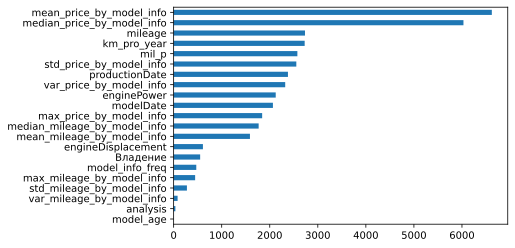

In [40]:
# Проверим их значимость
nums = pd.Series(f_regression(train_data[numerical_features], train_data['price'])[0], index = numerical_features)
nums.sort_values(inplace = True)
nums.plot(kind = 'barh')

<AxesSubplot:>

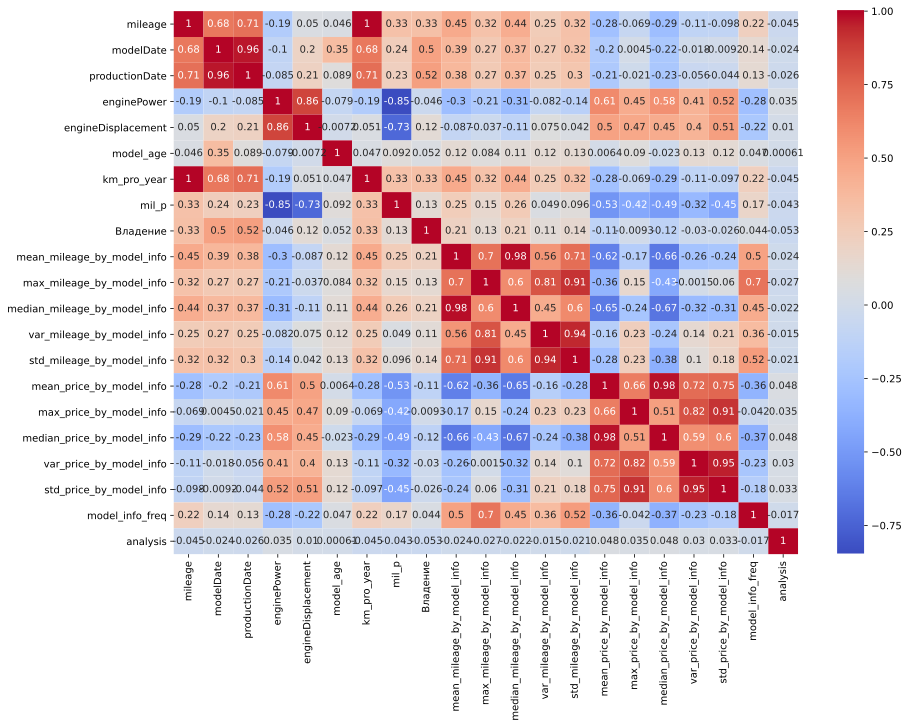

In [41]:
# И корреляцию
import seaborn as sns
correlation = train_data[numerical_features].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

Существует сильная корреляция между объемом двигателя и мощностью. Пробег имеет сильную корреляцию с возрастными характеристиками и соотношением пробег/возраст. Возрастные характеристики коррелируют друг с другом. 

# 2. Расчёты на основе подготовленных данных
## 2.1 Maschine Learning
### 2.1.1 Модель CatboostRegressor

In [42]:
#Подготовим датасеты для подстановки в модель
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)


In [43]:
#Подготовим датафрейм, чтобы аккумулировать результаты по моделям и сравнивать их в единой таблице
df_cum = pd.DataFrame(columns=['test MAPE','model', 'description','submission file'])
df_cum.info()


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   test MAPE        0 non-null      object
 1   model            0 non-null      object
 2   description      0 non-null      object
 3   submission file  0 non-null      object
dtypes: object(4)
memory usage: 0.0+ bytes


In [44]:
model1 = CatBoostRegressor(iterations = 8000,
                          depth=8,
                          learning_rate = 0.01,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=1000,
                          #task_type='GPU',
                         )
model1.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         #plot=True
         )

0:	learn: 0.0423310	test: 0.0423960	best: 0.0423960 (0)	total: 68.3ms	remaining: 9m 6s
500:	learn: 0.0086050	test: 0.0087760	best: 0.0087760 (500)	total: 6.1s	remaining: 1m 31s
1000:	learn: 0.0075239	test: 0.0080752	best: 0.0080752 (1000)	total: 11.9s	remaining: 1m 23s
1500:	learn: 0.0069369	test: 0.0078044	best: 0.0078042 (1499)	total: 18s	remaining: 1m 17s
2000:	learn: 0.0065085	test: 0.0076419	best: 0.0076419 (2000)	total: 24.2s	remaining: 1m 12s
2500:	learn: 0.0061716	test: 0.0075527	best: 0.0075527 (2496)	total: 30.1s	remaining: 1m 6s
3000:	learn: 0.0058647	test: 0.0074742	best: 0.0074742 (3000)	total: 35.7s	remaining: 59.5s
3500:	learn: 0.0055871	test: 0.0074205	best: 0.0074205 (3500)	total: 41.7s	remaining: 53.6s
4000:	learn: 0.0053454	test: 0.0073803	best: 0.0073802 (3994)	total: 47.3s	remaining: 47.3s
4500:	learn: 0.0051178	test: 0.0073627	best: 0.0073627 (4500)	total: 53.2s	remaining: 41.3s
5000:	learn: 0.0049259	test: 0.0073440	best: 0.0073438 (4997)	total: 59.6s	remaining: 

In [45]:
test_predict_catboost = model1.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.4f}%")

TEST mape: 0.7319%


In [46]:
# для контроля посмотрим MAPE в обычном масштабе
test_predict_catboost_reg = np.exp(test_predict_catboost)
y_test_reg = np.exp(y_test)
print(f"TEST mape: {(mape(y_test_reg, test_predict_catboost_reg))*100:0.4f}%")

TEST mape: 10.5487%


In [47]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'CatboostRegressor', 'стандарт', mape(y_test_reg, test_predict_catboost_reg)*100, 'catboost_submission.csv')

,test MAPE,model,description,submission file
0,10.548731,CatboostRegressor,стандарт,catboost_submission.csv


In [48]:
sub_predict_catboost = model1.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission['price'] = np.round(sample_submission['price'].apply(lambda x: math.exp(x)).values, 0)
sample_submission.to_csv('catboost_submission.csv', index=False)

### 2.1.2 Модель GradientBoostingRegressor 

In [49]:
from sklearn.ensemble import GradientBoostingRegressor

model2 = GradientBoostingRegressor(criterion='mse', # параметры подобраны с помощью GridSearchCV (здесь удалено ввиду длительности процесса)
                                     max_depth=8,
                                     min_samples_leaf=21,
                                     random_state=42,  
                                     n_estimators=4000, 
                                     max_features='sqrt',
                                     
                                     loss='huber', 
                                     learning_rate=0.026)

model2.fit(X_train, y_train)

y_train_pred =model2.predict(X_train) 

print(f"TEST mape: {(mape(y_train, y_train_pred))*100:0.2f}%")

TEST mape: 0.39%


In [50]:
test_predict_gb = model2.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_gb))*100:0.2f}%")

TEST mape: 0.76%


In [51]:
# для контроля посмотрим MAPE в обычном масштабе
test_predict_gb_reg = np.exp(test_predict_gb)
y_test_reg = np.exp(y_test)
print(f"TEST mape: {(mape(y_test_reg, test_predict_gb_reg))*100:0.4f}%")

TEST mape: 10.6873%


# Применим VotingRegressor для улучшения результатов работы двух моделей

In [52]:
from sklearn.ensemble import VotingRegressor
ensemble=VotingRegressor(estimators=[('GradientBoostingRegressor', model2), ('Catboost', model1)], 
                        weights=[0.5,0.5]).fit(X_train,y_train)
print('The accuracy for Grad and Catboost is:',ensemble.score(X_test,y_test))
# не получилось заставить его не выводить каждую строку на печать, поэтому вот так... 

0:	learn: 0.0423310	total: 12.7ms	remaining: 1m 41s
1:	learn: 0.0419936	total: 24.5ms	remaining: 1m 37s
2:	learn: 0.0416495	total: 36.5ms	remaining: 1m 37s
3:	learn: 0.0413178	total: 49.1ms	remaining: 1m 38s
4:	learn: 0.0409889	total: 61.3ms	remaining: 1m 38s
5:	learn: 0.0406510	total: 73.8ms	remaining: 1m 38s
6:	learn: 0.0403167	total: 85.6ms	remaining: 1m 37s
7:	learn: 0.0399829	total: 96.9ms	remaining: 1m 36s
8:	learn: 0.0396658	total: 108ms	remaining: 1m 35s
9:	learn: 0.0393392	total: 120ms	remaining: 1m 35s
10:	learn: 0.0390319	total: 131ms	remaining: 1m 35s
11:	learn: 0.0387275	total: 143ms	remaining: 1m 34s
12:	learn: 0.0384096	total: 154ms	remaining: 1m 34s
13:	learn: 0.0381011	total: 165ms	remaining: 1m 34s
14:	learn: 0.0378027	total: 176ms	remaining: 1m 33s
15:	learn: 0.0374968	total: 188ms	remaining: 1m 33s
16:	learn: 0.0372009	total: 200ms	remaining: 1m 33s
17:	learn: 0.0369051	total: 211ms	remaining: 1m 33s
18:	learn: 0.0366099	total: 236ms	remaining: 1m 39s
19:	learn: 0.0

In [53]:
y_pred1 = ensemble.predict(X_test)
print(f"TEST mape: {(mape(y_test_reg, np.exp(y_pred1)))*100:0.2f}%")

TEST mape: 10.43%


In [54]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'ensemble', 'Grad and Catboost', mape(y_test_reg, np.exp(y_pred1))*100, 'ensemble_submission.csv')

,test MAPE,model,description,submission file
0,10.548731,CatboostRegressor,стандарт,catboost_submission.csv
1,10.430821,ensemble,Grad and Catboost,ensemble_submission.csv


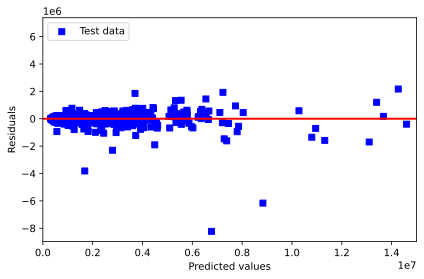

In [55]:
# анализ результата работы модели

#plt.scatter(test_predict_catboost_reg,  y_train_pred - y_train,
#            c='blue', marker='o', label='Training data')
plt.scatter(np.exp(y_pred1),  np.exp(y_pred1) - y_test_reg,
            c='blue', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=15000000, lw=2, color='red')
plt.xlim([-10, 15000000])
plt.tight_layout()

как видно на графике - модель дает существенные ошибки на автомобилях с ценой свыше 6 млн рублей

In [56]:
# проверим количество ошибок и их масштаб
X_train['price_predict'] = np.exp(y_train_pred)
X_train ['loss'] = np.exp(y_train) - X_train.price_predict

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
X_train ['loss']

7320   -226470.394346
8037    139960.243056
4681    -28358.634654
6014    -11560.517431
3649    111511.688994
            ...      
5443     76864.263504
6862    -19418.746622
6897    -64115.922660
7061     76003.463976
2531     51162.123349
Name: loss, Length: 5679, dtype: float64

In [58]:
X_train[(X_train.loss == 0)].index # нет ни одного точного попадания...

Int64Index([], dtype='int64')

In [59]:
X_train[(X_train.loss > -1000)&(X_train.loss < 1000)] # 84 ответа с ошибкой от -1000 до 1000 рублей. 

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,model_age,km_pro_year,mil_p,mean_mileage_by_model_info,...,lux_0,lux_1,low_MtA_0,high_MtA_0,dealer_0,dealer_1,залог_0,залог_1,price_predict,loss
7329,0.186441,0.1360,0.203999,0.250000,0.236842,0.088036,0.222222,0.202275,0.461794,0.472379,...,1,0,1,1,1,0,1,0,5.792434e+05,756.588119
1730,0.677966,0.6080,0.047099,0.083333,0.026316,0.051919,0.222222,0.046516,0.134838,0.188357,...,1,0,1,1,1,0,0,1,6.578760e+06,-859.839995
3016,0.389831,0.3696,0.146939,0.250000,0.236842,0.088036,0.222222,0.145697,0.229233,0.350039,...,1,0,1,1,1,0,1,0,1.156855e+06,144.687289
8025,0.186441,0.2064,0.126172,0.166667,0.184211,0.106095,0.111111,0.124981,0.345073,0.333435,...,1,0,1,1,0,1,1,0,9.451605e+05,439.469876
2505,0.389831,0.2640,0.178999,0.250000,0.236842,0.101580,0.222222,0.177486,0.300586,0.358917,...,1,0,1,1,1,0,1,0,1.150818e+06,-817.831263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,0.389831,0.3696,0.130440,0.250000,0.210526,0.119639,0.277778,0.129273,0.226821,0.350039,...,1,0,1,1,1,0,1,0,1.349362e+06,638.423428
7465,0.406780,0.2880,0.191999,0.312500,0.368421,0.379233,0.111111,0.190851,0.283920,0.497344,...,1,0,1,1,1,0,1,0,4.701786e+05,-178.611052
3698,0.389831,0.2784,0.131749,0.187500,0.184211,0.173815,0.166667,0.130506,0.281672,0.424246,...,1,0,1,1,1,0,1,0,1.560199e+06,-198.530393
2646,0.389831,0.2608,0.156461,0.208333,0.263158,0.097065,0.055556,0.155216,0.299707,0.467249,...,1,0,1,1,1,0,1,0,1.300983e+06,-982.726648


In [60]:
X_train[(X_train.loss > X_train.loss.quantile(0.9))].index # по индексу максимальных ошибок можно ознакомиться с авто и их описанием в data



Int64Index([8037, 5702, 4577, 7715, 6883, 3675, 8349, 4300, 7219, 3977,
            ...
            2687, 6469, 6896, 2692, 5561, 4418, 5788, 2855, 4104, 7249],
           dtype='int64', length=568)

In [61]:
sub_predict_ensemble = ensemble.predict(X_sub)
sample_submission['price'] = np.exp(sub_predict_ensemble)
sample_submission.to_csv('ensemble_submission.csv', index=False)

## 2.2 Подключаем Deep Learning
### 2.2.1 Делаем нейросеть на табличных данных

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)


In [63]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [64]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [65]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [66]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=1000, # фактически мы обучаем пока EarlyStopping не остановит обучение. 
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

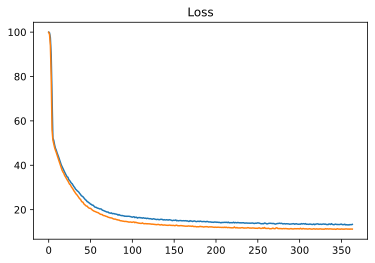

In [67]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [68]:
#Сохраняем веса обученной модели
model.save('../working/nn_1.hdf5')


In [69]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.15%


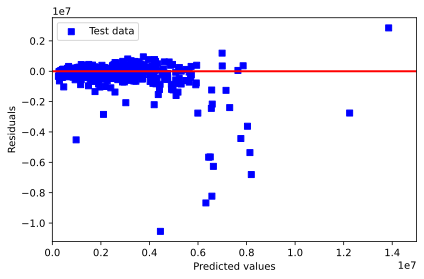

In [70]:
# анализ результата работы модели

#plt.scatter(test_predict_catboost_reg,  y_train_pred - y_train,
#            c='blue', marker='o', label='Training data')
plt.scatter(test_predict_nn1[:,0],  test_predict_nn1[:,0] - y_test,
            c='blue', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=15000000, lw=2, color='red')
plt.xlim([-10, 15000000])
plt.tight_layout()

По-прежнему существенные ошибки на авто дороже 6 млн.

In [71]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

In [72]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'Neuro Net 1', 'табличная', mape(y_test, test_predict_nn1[:,0])*100, 'nn1_submission.csv')

,test MAPE,model,description,submission file
0,10.548731,CatboostRegressor,стандарт,catboost_submission.csv
1,10.430821,ensemble,Grad and Catboost,ensemble_submission.csv
2,11.151175,Neuro Net 1,табличная,nn1_submission.csv


In [73]:
# Смешаем нейросеть и ensemble, проверим МAPE.
blend_predict1 = (np.exp(y_pred1)*0.7 + test_predict_nn1[:,0]*0.3) 
print(f"TEST mape: {(mape(y_test, blend_predict1))*100:0.2f}%")

TEST mape: 10.17%


In [74]:
blend_sub_predict1 = (sub_predict_ensemble*0.7 + sub_predict_nn1[:,0]*0.3) 
sample_submission['price'] = blend_sub_predict1
sample_submission.to_csv('blend_submission_nn1.csv', index=False)

In [75]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'Blend 1', 'табличная + ensemble', mape(y_test, blend_predict1)*100, 'blend_submission_nn1.csv')

,test MAPE,model,description,submission file
0,10.548731,CatboostRegressor,стандарт,catboost_submission.csv
1,10.430821,ensemble,Grad and Catboost,ensemble_submission.csv
2,11.151175,Neuro Net 1,табличная,nn1_submission.csv
3,10.169196,Blend 1,табличная + ensemble,blend_submission_nn1.csv


### 2.2.2 Подключим в модель блок NLP

In [76]:
# В описаниях находим 5 пустых значений и заменяем их на подобные
data['description_1'] = data['description'].apply(lambda x: len(x))
data[data['description_1'] == 1]['description']

388       
1005     .
4265    \n
6381     .
8283     Ц
Name: description, dtype: object

In [77]:
data['description'].loc[388] = data['description'].loc[7069]
data['description'].loc[1005] = data['description'].loc[4753]
data['description'].loc[4265] = data['description'].loc[7448]
data['description'].loc[6381] = data['description'].loc[3004]
data['description'].loc[8283] = data['description'].loc[8349]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [78]:
# Добавим для информативности в описания данные из других колонок
data.description = data.brand + ' ' + data.bodyType + ' ' +\
                   data.enginePower.apply(lambda x: str(x)) +  ' ' + 'лс' + ' ' +\
                   data.productionDate.apply(lambda x: str(x)) + ' ' + 'год' + ' ' + data.description

In [79]:
data['description']

0       MERCEDES универсал 5 дв. 220 лс 30 год Всем пр...
1       BMW купе 313 лс 8 год Продаю любимейшую тачилу...
2       BMW купе 218 лс 13 год Машина тут продаётся не...
3       BMW седан 136 лс 14 год Автомобиль в отличном ...
4       BMW седан 190 лс 2 год Немка! с бесключивым до...
                              ...                        
8348    BMW седан 150 лс 15 год Продаётся любимый авто...
8349    BMW седан 190 лс 5 год Куплена у официального ...
8350    BMW седан 143 лс 13 год Торг на месте. Все раб...
8351    AUDI седан 310 лс 5 год Автомобиль в отличном ...
8352    MERCEDES лимузин 394 лс 25 год Удлиненный заво...
Name: description, Length: 8353, dtype: object

In [80]:
# Сделаем лемматизацию и уберем стоп-слова из текстов объявлений
!pip install pymystem3

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian") # удаляет предлоги союзы и пр.

# Исключим из стоп-листа 'не'
operators = set(('не', 'не'))
russian_stopwords = set(russian_stopwords) - operators

def lemma_text(text):
        
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

#Example    
lemma_text("Машина тут продаётся не в первый раз, НО!")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


'машина продаваться не первый'

In [82]:
# Благодаря лемматизации кол-во токенов в словаре tokenize.word_index
# уменьшается с 39591 до 22329
data.description = data.description.apply(lambda x: lemma_text(x))
data.description[10]


'mercedes родстер 231 лс 30 год отрывать сердце красавец не идеальный состояние сожаление самый средство заниматься полный восстановление поэтому решать отдавать хороший рука смочь довезти ум уникальный машина автомобиль право отчуждение !!! возможно ездить доверенность птс указывать 150 л факт 231 л'

In [83]:
patterns = "[!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-•―☛。«❤️✅✔₽➥]"

for i in range (1,8353):
    data['description'][i] = data['description'][i].replace (patterns, '')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [84]:
# TOKENIZER
# The maximum number of words to be used
MAX_WORDS = 50000 # 50000
# Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 256 # 256

In [85]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

In [86]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.13 s, sys: 2.74 ms, total: 1.14 s
Wall time: 1.14 s


In [87]:
len(tokenize.word_index)

22500

In [88]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.14 s, sys: 2.74 ms, total: 1.15 s
Wall time: 1.14 s


In [89]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH, name='nlp1'))
model_nlp.add(L.GRU(256, return_sequences=True, name='nlp2'))# в процессе выполнения проекта использовались и LSTM слои и GRU. GRU показал результат лучше
model_nlp.add(L.Dropout(0.5)) # также пробовали различные вариации. Выбрано такое значение ввиду переобучения модели.
model_nlp.add(L.GRU(128, name='nlp3'))# LSTM # 256 и 128
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu", name='nlp4'))
model_nlp.add(L.Dropout(0.25))

In [90]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu", name='mlp1'))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu", name='mlp2'))
model_mlp.add(L.Dropout(0.5))

In [91]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output], name='comb1')
# being our regression head
head = L.Dense(256, activation="relu", name='comb2')(combinedInput)
head = L.Dense(1, activation="linear", name='comb3')(head)

model_1 = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head, name='model_1')

In [92]:
optimizer = tf.keras.optimizers.Adam(0.005)
model_1.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [93]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [94]:
history = model_1.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение.
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 7s 287ms/step - loss: 99.9979 - MAPE: 99.9979 - val_loss: 99.9348 - val_MAPE: 99.9348
Epoch 2/500
12/12 [==============================] - 3s 230ms/step - loss: 99.6970 - MAPE: 99.6970 - val_loss: 97.2568 - val_MAPE: 97.2568
Epoch 3/500
12/12 [==============================] - 3s 222ms/step - loss: 94.0525 - MAPE: 94.0525 - val_loss: 72.0980 - val_MAPE: 72.0980
Epoch 4/500
12/12 [==============================] - 3s 226ms/step - loss: 62.6357 - MAPE: 62.6357 - val_loss: 56.1015 - val_MAPE: 56.1015
Epoch 5/500
12/12 [==============================] - 3s 221ms/step - loss: 52.4444 - MAPE: 52.4444 - val_loss: 49.3168 - val_MAPE: 49.3168
Epoch 6/500
12/12 [==============================] - 3s 230ms/step - loss: 48.9338 - MAPE: 48.9338 - val_loss: 46.3717 - val_MAPE: 46.3717
Epoch 7/500
12/12 [==============================] - 3s 232ms/step - loss: 45.9729 - MAPE: 45.9729 - val_loss: 44.2964 - val_MAPE: 44.2964
Epoch 8/500
12/12 [========

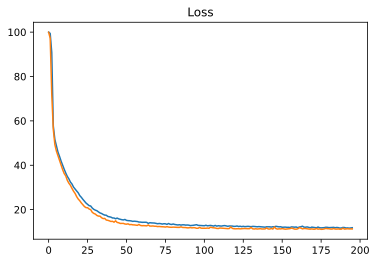

In [95]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [96]:
model_1.save('../working/nn_mlp_nlp.hdf5')


In [97]:
test_predict_nn2 = model_1.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.12%


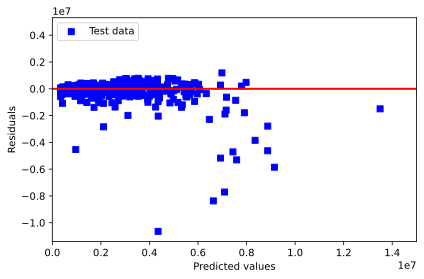

In [98]:
# анализ результата работы модели

#plt.scatter(test_predict_catboost_reg,  y_train_pred - y_train,
#            c='blue', marker='o', label='Training data')
plt.scatter(test_predict_nn2[:,0],  test_predict_nn2[:,0] - y_test,
            c='blue', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=15000000, lw=2, color='red')
plt.xlim([-10, 15000000])
plt.tight_layout()

Все также 

In [99]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'Neuro Net 2', 'табличная + NLP', mape(y_test, test_predict_nn2[:,0])*100, 'nn2_submission.csv')

,test MAPE,model,description,submission file
0,10.548731,CatboostRegressor,стандарт,catboost_submission.csv
1,10.430821,ensemble,Grad and Catboost,ensemble_submission.csv
2,11.151175,Neuro Net 1,табличная,nn1_submission.csv
3,10.169196,Blend 1,табличная + ensemble,blend_submission_nn1.csv
4,11.123635,Neuro Net 2,табличная + NLP,nn2_submission.csv


In [100]:
# Смешаем нейросеть и ensemble, проверим МAPE.
blend_predict2 = (np.exp(y_pred1)*0.7 + test_predict_nn2[:,0]*0.3) 
print(f"TEST mape: {(mape(y_test, blend_predict2))*100:0.2f}%")

TEST mape: 10.22%


In [101]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'Blend 2', 'ensemble + NLP', mape(y_test, blend_predict2)*100, 'blend_submission_nn2.csv')

,test MAPE,model,description,submission file
0,10.548731,CatboostRegressor,стандарт,catboost_submission.csv
1,10.430821,ensemble,Grad and Catboost,ensemble_submission.csv
2,11.151175,Neuro Net 1,табличная,nn1_submission.csv
3,10.169196,Blend 1,табличная + ensemble,blend_submission_nn1.csv
4,11.123635,Neuro Net 2,табличная + NLP,nn2_submission.csv
5,10.224898,Blend 2,ensemble + NLP,blend_submission_nn2.csv


In [102]:
sub_predict_nn2 = model_1.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

### 2.2.3 Добавим в нейросеть фото

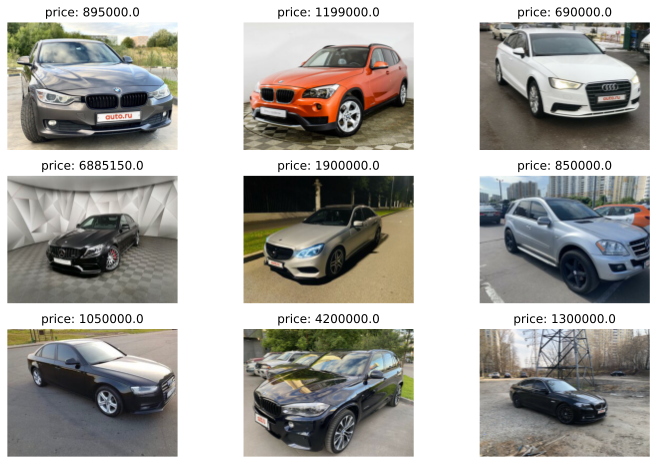

In [103]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [104]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


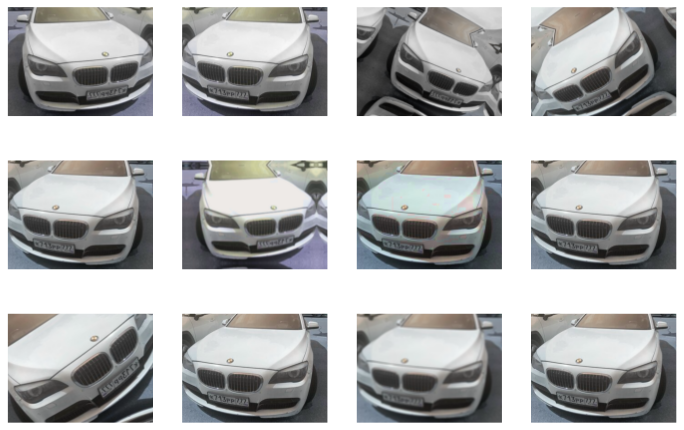

In [105]:
# Для аугментации используем Albumentations
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, RandomShadow, 
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

augmentation = Compose([
    HorizontalFlip(p=0.4),
    OneOf([
        RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15),
        RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05)
    ],p=0.3),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.45),
    Blur(p=0.15),
    HueSaturationValue(p=0.25),
    #RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.25),
])

#пример
plt.figure(figsize = (12,8))
for i in range(12):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [106]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

In [107]:
# Используем предобученную EfficientNetB6. Модель выбрана перебором
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

165240832/165234480 [==============================] - 4s 0us/step


In [108]:
#строим нейросеть для анализа табличных данных. В ходе выполнения проекта пытались подавать 
# на вход уже обученную на предыдущих этапах модель но показатели были хуже
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [109]:
# NLP. В ходе выполнения проекта пытались подавать 
# на вход уже обученную на предыдущих этапах модель но показатели были хуже
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.GRU(256, return_sequences=True),
    L.Dropout(0.5),
    L.GRU(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [110]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

# Fine tuning

In [111]:
# Не тренируем часть с картинками
efficientnet_model.trainable = False

In [112]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')# best_model
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [113]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [114]:
history = model.fit(train_dataset.batch(30),
                    epochs=20,#Было 20
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/20
190/190 [==============================] - 88s 367ms/step - loss: 65.7598 - MAPE: 65.7598 - val_loss: 30.5363 - val_MAPE: 30.5363
Epoch 2/20
190/190 [==============================] - 66s 347ms/step - loss: 29.0491 - MAPE: 29.0491 - val_loss: 19.4226 - val_MAPE: 19.4226
Epoch 3/20
190/190 [==============================] - 65s 339ms/step - loss: 21.8117 - MAPE: 21.8117 - val_loss: 17.6749 - val_MAPE: 17.6749
Epoch 4/20
190/190 [==============================] - 65s 340ms/step - loss: 18.9417 - MAPE: 18.9417 - val_loss: 15.2317 - val_MAPE: 15.2317
Epoch 5/20
190/190 [==============================] - 65s 339ms/step - loss: 17.1859 - MAPE: 17.1859 - val_loss: 13.8610 - val_MAPE: 13.8610
Epoch 6/20
190/190 [==============================] - 64s 338ms/step - loss: 16.3042 - MAPE: 16.3042 - val_loss: 13.9814 - val_MAPE: 13.9814
Epoch 7/20
190/190 [==============================] - 65s 340ms/step - loss: 15.9916 - MAPE: 15.9916 - val_loss: 13.0936 - val_MAPE: 13.0936
Epoch 8/20
19

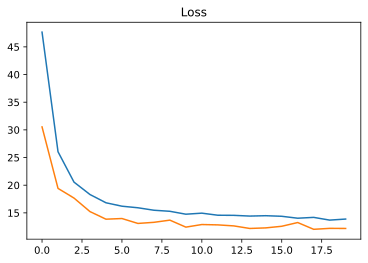

In [115]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [116]:
model.save('../working/nn_final.hdf5')

In [117]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.19%


In [118]:
efficientnet_model.trainable = True

# разморозим половину слоев модели
fine_tune_at = len(efficientnet_model.layers)//2


for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False
len(efficientnet_model.trainable_variables)

292

In [119]:
model.load_weights('../working/best_model.hdf5')

In [120]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [121]:
history = model.fit(train_dataset.batch(30),
                    epochs=20,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/20
190/190 [==============================] - 129s 570ms/step - loss: 13.3110 - MAPE: 13.3110 - val_loss: 43.8046 - val_MAPE: 43.8046
Epoch 2/20
190/190 [==============================] - 104s 545ms/step - loss: 13.0772 - MAPE: 13.0772 - val_loss: 11.9939 - val_MAPE: 11.9939
Epoch 3/20
190/190 [==============================] - 104s 546ms/step - loss: 12.9286 - MAPE: 12.9286 - val_loss: 16.9244 - val_MAPE: 16.9244
Epoch 4/20
190/190 [==============================] - 104s 545ms/step - loss: 13.3704 - MAPE: 13.3704 - val_loss: 12.7121 - val_MAPE: 12.7121
Epoch 5/20
190/190 [==============================] - 104s 547ms/step - loss: 13.1012 - MAPE: 13.1012 - val_loss: 90.4046 - val_MAPE: 90.4046
Epoch 6/20
190/190 [==============================] - 104s 547ms/step - loss: 12.9464 - MAPE: 12.9464 - val_loss: 25.6805 - val_MAPE: 25.6805
Epoch 7/20
190/190 [==============================] - 104s 545ms/step - loss: 12.6220 - MAPE: 12.6220 - val_loss: 13.1540 - val_MAPE: 13.1540
Epoch 

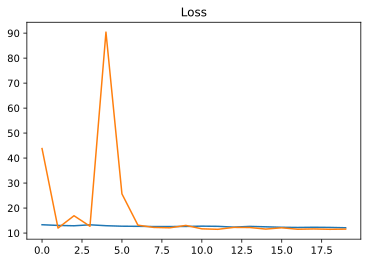

In [122]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [123]:
model.save('../working/nn_final.hdf5')

In [124]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.57%


In [125]:
efficientnet_model.trainable = True #разморозим все слои 
len(efficientnet_model.trainable_variables)

582

In [126]:
model.load_weights('../working/best_model.hdf5')

In [127]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [128]:
history = model.fit(train_dataset.batch(20),
                    epochs=5,
                    validation_data = test_dataset.batch(20),
                    callbacks=callbacks_list
                   )

Epoch 1/5
284/284 [==============================] - 299s 969ms/step - loss: 11.8818 - MAPE: 11.8818 - val_loss: 11.1883 - val_MAPE: 11.1883
Epoch 2/5
284/284 [==============================] - 267s 941ms/step - loss: 11.8371 - MAPE: 11.8371 - val_loss: 11.1410 - val_MAPE: 11.1410
Epoch 3/5
284/284 [==============================] - 268s 943ms/step - loss: 11.5188 - MAPE: 11.5188 - val_loss: 11.2275 - val_MAPE: 11.2275
Epoch 4/5
284/284 [==============================] - 268s 942ms/step - loss: 11.6178 - MAPE: 11.6178 - val_loss: 11.2774 - val_MAPE: 11.2774
Epoch 5/5
284/284 [==============================] - 268s 942ms/step - loss: 11.6400 - MAPE: 11.6400 - val_loss: 11.2817 - val_MAPE: 11.2817


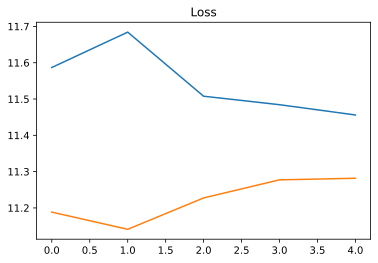

In [129]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [130]:
model.save('../working/nn_final.hdf5')

In [131]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.28%


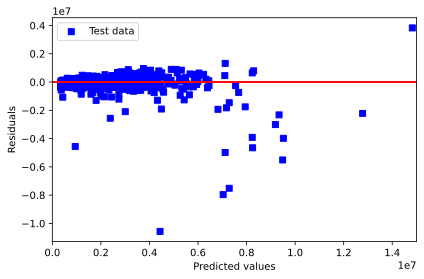

In [132]:
# анализ результата работы модели

#plt.scatter(test_predict_catboost_reg,  y_train_pred - y_train,
#            c='blue', marker='o', label='Training data')
plt.scatter(test_predict_nn3[:,0],  test_predict_nn3[:,0] - y_test,
            c='blue', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=15000000, lw=2, color='red')
plt.xlim([-10, 15000000])
plt.tight_layout()

In [133]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'Neuro Net 3', 'табличная + NLP + фото', mape(y_test, test_predict_nn3[:,0])*100, 'nn3_submission.csv')

,test MAPE,model,description,submission file
0,10.548731,CatboostRegressor,стандарт,catboost_submission.csv
1,10.430821,ensemble,Grad and Catboost,ensemble_submission.csv
2,11.151175,Neuro Net 1,табличная,nn1_submission.csv
3,10.169196,Blend 1,табличная + ensemble,blend_submission_nn1.csv
4,11.123635,Neuro Net 2,табличная + NLP,nn2_submission.csv
5,10.224898,Blend 2,ensemble + NLP,blend_submission_nn2.csv
6,11.281681,Neuro Net 3,табличная + NLP + фото,nn3_submission.csv


In [134]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = np.round(sub_predict_nn3[:,0], 0)
sample_submission.to_csv('nn3_submission.csv', index=False)
sample_submission.head(3)

,sell_id,price
0,1099427284,418922.0
1,1096405886,2532601.0
2,1100195294,603611.0


In [135]:
blend_predict = (np.exp(y_pred1)*0.8+ test_predict_nn3[:,0]*0.2)
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.22%


In [136]:
blend_predict = (np.exp(y_pred1)*0.8+ test_predict_nn3[:,0]*0.1 + test_predict_nn2[:,0]*0.1)
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.22%


In [137]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'Blend 2', 'nn3 + catboost + веса', (mape(y_test, blend_predict))*100, 'blend_submission2.csv')

,test MAPE,model,description,submission file
0,10.548731,CatboostRegressor,стандарт,catboost_submission.csv
1,10.430821,ensemble,Grad and Catboost,ensemble_submission.csv
2,11.151175,Neuro Net 1,табличная,nn1_submission.csv
3,10.169196,Blend 1,табличная + ensemble,blend_submission_nn1.csv
4,11.123635,Neuro Net 2,табличная + NLP,nn2_submission.csv
5,10.224898,Blend 2,ensemble + NLP,blend_submission_nn2.csv
6,11.281681,Neuro Net 3,табличная + NLP + фото,nn3_submission.csv
7,10.222413,Blend 2,nn3 + catboost + веса,blend_submission2.csv


In [138]:
blend_sub_predict = np.round((np.exp(sub_predict_ensemble)*0.8 + sub_predict_nn3[:,0]*0.2), 0)
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission2.csv', index=False)

In [139]:
blend_sub_predict = np.round((np.exp(sub_predict_ensemble)+ np.round(sub_predict_nn3[:,0], 0))/2, 0)
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission3.csv', index=False)

In [140]:
#Добавим расчет в сводную таблицу
cumulated_res(df_cum, 'Blend 3', 'nn3 + catboost', '?', 'blend_submission3.csv')

,test MAPE,model,description,submission file
0,10.5487,CatboostRegressor,стандарт,catboost_submission.csv
1,10.4308,ensemble,Grad and Catboost,ensemble_submission.csv
2,11.1512,Neuro Net 1,табличная,nn1_submission.csv
3,10.1692,Blend 1,табличная + ensemble,blend_submission_nn1.csv
4,11.1236,Neuro Net 2,табличная + NLP,nn2_submission.csv
5,10.2249,Blend 2,ensemble + NLP,blend_submission_nn2.csv
6,11.2817,Neuro Net 3,табличная + NLP + фото,nn3_submission.csv
7,10.2224,Blend 2,nn3 + catboost + веса,blend_submission2.csv
8,?,Blend 3,nn3 + catboost,blend_submission3.csv


# Краткое изложение и выводы¶
В рамках проекта было сделано следующее:
- инициализированы необходимые библиотеки, заданы условия визуализации и загружен набор данных.
- мы провели EDA, очистили и обработали табличную информацию.
- обучили 2 модели - CatBoost и Gradienboosting с последующим применением votingregressor для усреднения результатов их работы.  
- обучена NN на табличных данных, улучшен результат с помощью подбора гиперпараметров.
- лемматизировали тексты, очистили их от символов и обучили НЛП на основе полученных данных.
- произвели аугментацию изображений и обучили NN, улучшив ее результат с помощью точной настройки.
- использовали fine tuning.
- использовали смешивание для усреднения результатов, в том числе, с применением весов.
- проведена последовательная оценка работы моделей с предметным анализом их ошибок.

В результате получилось улучшить результат относительно baseline на 1,86519 (итоговый результат на Kaggle = 10.84210, 8 место).

Из полученных результатов можно сделать следующие выводы:

Выполненная работа позволяет прогнозировать стоимость автобилей со средней ошибкой в 10.8 %. По нашему мнению эта ошибка значительна, но при проведении анализа работы моделей было установлено, что, основной вклад в усредненную ошибку вносят нестандартные модели авто. Так, например, в нашем датасете присутствуют бронированные автомобили. Кроме того, цена выставляемого на продажу автомобиля не всегда соответствует его реальной цене, зачастую она завышена.

Что планировалось сделать, но не успели:
- увеличение изображений (на предыдущем проекте давало неплохой прирост качества)
- ТТА
- также необходимо более детально работать с текстовой частью